# Import

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyrr import Quaternion, Vector3

from revolve2.modular_robot.body import AttachmentPoint, Module
from revolve2.modular_robot.body.v2 import ActiveHingeV2, BodyV2, BrickV2
from revolve2.ci_group.morphological_measures import MorphologicalMeasures

import seaborn as sns
import shutil

C:\Users\niels\AppData\Local\Temp\ipykernel_13448\3603862544.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Some Functions

In [2]:
def rotate(a: Vector3, b: Vector3, rotation: Quaternion) -> Vector3:
    """
    Goal:
        Rotates vector a a given angle around b.
    --------------------------------------------------------
    Input:
        a:
            Vector a.
        b:
            Vector b.
        rotation:
            The quaternion for rotation.
    --------------------------------------------------------
    Output:
        A copy of a, rotated.
    """
    cos_angle: int = int(round(np.cos(rotation.angle)))
    sin_angle: int = int(round(np.sin(rotation.angle)))

    vec: Vector3 = (
        a * cos_angle + sin_angle * b.cross(a) + (1 - cos_angle) * b.dot(a) * b
    )
    return vec


def vec3_int(vector: Vector3) -> Vector3[np.int_]:
    """
    Goal:
        Cast a Vector3 object to an integer only Vector3.
    --------------------------------------------------------
    Input:
        vector:
            The vector.
    --------------------------------------------------------
    Output:
        The integer vector.
    """
    x, y, z = map(lambda v: int(round(v)), vector)
    return Vector3([x, y, z], dtype=np.int64)

def pos2lin(position: Vector3[int], shape0: int) -> int:
    """Goal:
        Position to linear index.
    --------------------------------------------------------
    Input:
        position:
            The position of the module.
        shape0:
            The number of modules in the first dimension.
    --------------------------------------------------------
    Output:
       The linear index of the module."""
    return int(position[0] * shape0 + position[1])


In [3]:
def get_body(max_parts: int, dict_coord: dict):
    """Goal:
        Create a body from a given dictionary.
    ------------------------------------------------------------------
    Input:
        max_parts: int
            The maximum number of parts.
        dict_coord: dict
            The dictionary that contains the building plan.
            {poslin: ["B" or "H", {attachment_point: rotation_index}]}
    ------------------------------------------------------------------
    Output:
        BodyV2
            The body that is created.
    """
    # ---- Initialize body
    body = BodyV2()
    v2_core = body.core_v2

    # ---- Return core if building plan is empty
    if dict_coord == None:
        return body
    
    # ---- Get the maximum number of parts and the core position in the grid
    max4grid = max(max_parts, 1)
    position_core = Vector3([max4grid + 2, max4grid + 2, 0], dtype = np.int_)

    # ---- Loop through all attachment faces
    for idx_attachment, attachment_face in v2_core.attachment_faces.items():
        # -- Initialize
        # Get forward --> No idea why but this works properly!
        if idx_attachment in [0, 2]:
            forward = Vector3([1, 0, 0])
        else:
            forward = Vector3([-1, 0, 0])
        # Get upward
        up = Vector3([0, 0, 1])
        
        # -- Get all attachment points
        attachment_point_tuples_all = list(attachment_face.attachment_points.items())
        ## Get the min and max values of the attachment points --> used to adapt the core position later on!
        # Offset of attachment points
        att_arr = [] 
        for att in attachment_point_tuples_all:
            transf_off = rotate(att[1].offset,up, att[1].orientation)
            att_arr.append(transf_off)
        att_arr = np.array(att_arr)
        # Min and max values of the attachment points
        min_values = att_arr.min(axis = 0)
        max_values = att_arr.max(axis = 0)

        # -- Get fourth attachment point --> only middle now
        for attup in attachment_point_tuples_all:
            if attup[0] == 4:
                break
        
        # -- Get relative location of slot within face
        # Rotate forward vector 
        forward4slot = rotate(forward, up, attup[1].orientation)
        # Get middle and divider
        middle = np.mean([min_values, max_values], axis = 0)
        divider = (max_values - middle) # maximum slot location - middle, both are transformed already
        divider[divider == 0] = 1 # To prevent division by zero
        # Transform offset
        offset_pos = rotate(attup[1].offset, up, attup[1].orientation) # Transform offset
        # Get relative location of slot within face
        rellocslot_raw = (offset_pos - middle)
        rellocslot = (rellocslot_raw / divider) # to -1, 0, 1
        # Add 1 additional for forward position --> 3 x 3 x 3 core instead of 1 x 1 x 1
        rellocslot = forward4slot + rellocslot

        # -- Get the linear index of the current position
        poslin_current = pos2lin(position_core + rellocslot, max4grid * 2 + 4)
        # Skip if the position is not in the dictionary
        if poslin_current not in dict_coord.keys():
            continue

        # -- Initialize modules
        modules = {poslin_current: {"module": attachment_face, "position": position_core, "forward": forward, "up": up}}
        tuples2cons = [att for att in attachment_point_tuples_all if att[0] in list(dict_coord[poslin_current][1].keys())]
        modules[poslin_current]["tuples"] = tuples2cons
        current_module = modules[poslin_current]
        
        # -- Build the body from current face
        while len(modules) != 0:
            # ---- Get attachment tuple
            attup = current_module["tuples"][0]

            # ---- Rotate vector a given angle around b, required due to change of orientation
            forward = rotate(current_module["forward"], current_module["up"], attup[1].orientation)

            # ---- Calculate new position
            position = vec3_int(current_module["position"] + forward + rellocslot) 
            # Get linear index
            poslin = pos2lin(position, max4grid * 2 + 4)

            # Get child type and rotation index
            child_type = BrickV2 if dict_coord[poslin][0] == "B" else ActiveHingeV2
            child_rotation_index = dict_coord[poslin_current][1][attup[0]]

            # ---- Set the new child
            angle = child_rotation_index * (np.pi / 2.0) # Index is 0 | 1 --> 0 pi | 0.5 pi
            child = child_type(angle)
            current_module["module"].set_child(child, attup[0])

            # ---- Rotate the up vector around the forward vector
            up = rotate(current_module["up"], forward, Quaternion.from_eulers([angle, 0, 0]))

            # ---- Store foreward and up vector
            tuples2cons = [att for att in list(child.attachment_points.items())
                        if att[0] in list(dict_coord[poslin][1].keys())]
            # If there are occupied attachment points, store the module
            if tuples2cons != []:
                modules[poslin] = {"module": child, "position": position, 
                                   "forward": forward, "up": up, "tuples": tuples2cons}
            else:
                del dict_coord[poslin]

            # ---- Delete the adressed attachment point
            current_module["tuples"] = current_module["tuples"][1:]

            # ---- Change module if all attachment points have been adressed
            if (len(current_module["tuples"]) == 0) and (len(modules) != 1):
                del modules[poslin_current]
                module_list = list(modules.values())
                current_module = module_list[np.random.choice(np.arange(len(module_list)))]
                poslin_current = pos2lin(current_module["position"], max4grid * 2 + 4)
                rellocslot = np.zeros(3, dtype = np.int32)
            elif len(current_module["tuples"]) == 0:
                break
            else: pass

    return body
            

# Open data

In [4]:
# Count data
if os.path.exists('C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\idcounts.csv'):
    df_counts = pd.read_csv('C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\idcounts.csv')
else: df_counts = pd.DataFrame([], columns = ["id_string"])

# Morphological measures
if os.path.exists("C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\morphological_measures.csv"):
    df = pd.read_csv("C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\morphological_measures.csv")
    # Increase counts of existing ids
    for idx, row in df.iterrows():
        df.loc[idx, "count"] = df_counts.loc[df_counts["id"] == row["id_string"], "count"].values[0]
else: df = pd.DataFrame([], columns = [])

# Get Bodies and store Measures

In [5]:
for max_parts in range(1, 21):
    # Print max parts as kind of progress indicator
    print("Max Parts: ", max_parts)
    # Open file for max_parts
    with open(f'C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\{max_parts}.json', 'r') as f:
        # Load data
        data = json.load(f)

        # Bodies are stored in a certain way, so we need to loop through the data
        # ---> max_parts: {nbricks: {nhinges: [string]}}
        for max_parts, dictparts in data.items():
            for bricks, dictbricks in dictparts.items():
                for hinges, dicthinges in dictbricks.items():
                    for string in dicthinges:
                        # New string?
                        if df.empty or (string not in df["id_string"].values):
                            # Get max_parts
                            splitted = string.split("|")
                            max_parts = int(splitted[0])
                            # Only core? or should we get the building plan?
                            if max_parts == 1:
                                dict_coord = None
                            elif len(splitted) == 2:
                                # ---- Get coordinate data
                                substring = splitted[1]
                                substring_split = substring.split("-")
                                # Fill dictionary with building plan
                                # --> {poslin: ["B" or "H", {attachment_point: rotation_index}]}
                                dict_coord = {}
                                i = 0
                                while (i != len(substring_split)) and (substring_split[i] != ""):
                                    # Linear coordinate
                                    coord = int(substring_split[i])
                                    # Information for that coordinate (type, attachment points and orientations)
                                    info = substring_split[i + 1]
                                    # Set type of module (Brick or Hinge)
                                    dict_coord[coord] = []
                                    dict_coord[coord].append(info[0])
                                    # Set attachment points and orientations
                                    if len(info[1:]) > 1:
                                        dict_coord[coord].append({})
                                        for j in range(int((len(info) - 1) / 2)):
                                            dict_coord[coord][1][int(info[1 + int(j * 2)])] = int(info[1 + (int(j * 2) + 1)])
                                    else:
                                        dict_coord[coord].append({})
                                    # Increase i
                                    i += 2
                            else:
                                raise ValueError("No substring found")
                            
                            # ---- Develop body
                            body = get_body(max_parts, dict_coord)
                            
                            # ---- Get morphological measures
                            morphology = MorphologicalMeasures(body = body, brain = np.nan, max_modules = 20)
                            
                            id_string = morphology.id_string
                            assert id_string == string, "ID string not equal to original string!"

                            nbricks = morphology.num_bricks
                            nhinges = morphology.num_active_hinges
                            assert (nhinges + nbricks + 1) == max_parts, "Number of parts not equal to max_parts!"

                            size = morphology.size
                            proportion2d = morphology.proportion_2d

                            single_neighbour_brick_ratio = morphology.single_neighbour_brick_ratio
                            single_neighbour_ratio = morphology.single_neighbour_ratio
                            double_neighbour_brick_and_active_hinge_ratio = morphology.double_neigbour_brick_and_active_hinge_ratio
                            maxrel_llimbs, meanrel_llimbs, stdrel_llimbs = morphology.length_of_limbsNiels
                            
                            joints = morphology.joints
                            joint_brick_ratio = morphology.joint_brick_ratio
                            symmetry = morphology.symmetry
                            coverage = morphology.coverage
                            branching = morphology.branching
                            surface_area = morphology.surface

                            # ---- Add to dataframe
                            df = pd.concat([df, pd.DataFrame([{ "bricks": nbricks, "hinges": nhinges, "modules": max_parts, "size": size, "proportion2d": proportion2d, 
                                                            "single_neighbour_brick_ratio": single_neighbour_brick_ratio, 
                                                            "single_neighbour_ratio": single_neighbour_ratio, "double_neighbour_brick_and_active_hinge_ratio": double_neighbour_brick_and_active_hinge_ratio, 
                                                            "maxrel_llimbs": maxrel_llimbs, "meanrel_llimbs": meanrel_llimbs, "stdrel_llimbs": stdrel_llimbs,
                                                                "joints": joints, "joint_brick_ratio": joint_brick_ratio, 
                                                            "symmetry": symmetry, "coverage": coverage, "branching": branching, "surface_area": surface_area,
                                                            "id_string": id_string, "count": df_counts.loc[df_counts["id"] == id_string, "count"].values[0]}])],
                                                                ignore_index=True)

# ---- Save data
df.to_csv("C:\\Users\\niels\\OneDrive\\Documenten\\GitHub\\revolve2\\morphological_measures.csv", index = False)

Max Parts:  1
Max Parts:  2
Max Parts:  3
Max Parts:  4
Max Parts:  5
Max Parts:  6
Max Parts:  7
Max Parts:  8
Max Parts:  9
Max Parts:  10
Max Parts:  11
Max Parts:  12
Max Parts:  13
Max Parts:  14
Max Parts:  15
Max Parts:  16
Max Parts:  17
Max Parts:  18
Max Parts:  19
Max Parts:  20


# Create Repository

In [6]:
# Remove and create a directory
os.system("rm -rf Morphology")
os.system("mkdir Morphology")

1

In [7]:
# Remove and create a subdirectory
if os.path.exists("Morphology/ScatterPlots"):
    shutil.rmtree("Morphology/ScatterPlots")
os.makedirs("Morphology/ScatterPlots")

# Remove and create a subdirectory
if os.path.exists("Morphology/Histograms"):
    shutil.rmtree("Morphology/Histograms")
os.makedirs("Morphology/Histograms")

# Remove and create a subdirectory
if os.path.exists("Morphology/ScatterUnique"):
    shutil.rmtree("Morphology/ScatterUnique")
os.makedirs("Morphology/ScatterUnique/log")
os.makedirs("Morphology/ScatterUnique/nonlog")

# Generate Scatter Plot

In [8]:
# Columns to plot
cols2plot = [col for col in df.columns if col not in ["id_string", "count"]]
# Plot
for icol1, col1 in enumerate(cols2plot):
    for col2 in cols2plot[icol1 + 1:]:
        if col1 != col2:
            print(f"Saving: {col1}_{col2}")
            plt.scatter(df[col1], df[col2])
            plt.xlabel(col1, fontsize = 16, fontweight = "bold")
            plt.ylabel(col2, fontsize = 16, fontweight = "bold")
            plt.grid()
            plt.savefig(f"Morphology/Scatterplots/{col1}_{col2}.png")
            plt.close()

Saving: bricks_hinges
Saving: bricks_modules
Saving: bricks_size
Saving: bricks_proportion2d
Saving: bricks_single_neighbour_brick_ratio
Saving: bricks_single_neighbour_ratio
Saving: bricks_double_neighbour_brick_and_active_hinge_ratio
Saving: bricks_maxrel_llimbs
Saving: bricks_meanrel_llimbs
Saving: bricks_stdrel_llimbs
Saving: bricks_joints
Saving: bricks_joint_brick_ratio
Saving: bricks_symmetry
Saving: bricks_coverage
Saving: bricks_branching
Saving: bricks_surface_area
Saving: hinges_modules
Saving: hinges_size
Saving: hinges_proportion2d
Saving: hinges_single_neighbour_brick_ratio
Saving: hinges_single_neighbour_ratio
Saving: hinges_double_neighbour_brick_and_active_hinge_ratio
Saving: hinges_maxrel_llimbs
Saving: hinges_meanrel_llimbs
Saving: hinges_stdrel_llimbs
Saving: hinges_joints
Saving: hinges_joint_brick_ratio
Saving: hinges_symmetry
Saving: hinges_coverage
Saving: hinges_branching
Saving: hinges_surface_area
Saving: modules_size
Saving: modules_proportion2d
Saving: modu

# Generate Histograms

In [9]:
for col in cols2plot:
    # Get the data
    grouped_data = df.groupby([col])["count"].sum()
    # Plot
    width = (grouped_data.index.max() - grouped_data.index.min()) / len(grouped_data.index) * 0.8
    plt.bar(grouped_data.index, grouped_data.values, width = width, align = "center")
    plt.xlabel(col, fontsize = 16, fontweight = "bold")
    plt.ylabel("Count", fontsize = 16, fontweight = "bold")

    # Set ticks
    if col in ["bricks", "hinges", "modules"]:
        xt = np.arange(grouped_data.index.min(), grouped_data.index.max() + 1, 1)
        plt.xticks(ticks = xt, labels = xt)
    else:
        xt = np.arange(np.floor(grouped_data.index.min() * 10) / 10, np.ceil(grouped_data.index.max() * 10) / 10 + 0.1, 0.1)
        xt = [round(x, 2) for x in xt]
        plt.xticks(ticks = xt, labels = xt, rotation = 90)
    plt.grid()
    # Print
    print("Saving: ", col)
    print("Minimum: ", grouped_data.index.min())
    print("Maximum: ", grouped_data.index.max())
    # Save
    plt.savefig(f"Morphology/Histograms/{col}.png")
    # Close
    plt.close()

Saving:  bricks
Minimum:  0
Maximum:  16
Saving:  hinges
Minimum:  0
Maximum:  17
Saving:  modules
Minimum:  1
Maximum:  20
Saving:  size
Minimum:  0.05
Maximum:  1.0
Saving:  proportion2d
Minimum:  0.2307692307692307
Maximum:  1.0
Saving:  single_neighbour_brick_ratio
Minimum:  0.0
Maximum:  1.0
Saving:  single_neighbour_ratio
Minimum:  0.0
Maximum:  1.25
Saving:  double_neighbour_brick_and_active_hinge_ratio
Minimum:  0.0
Maximum:  1.0
Saving:  maxrel_llimbs
Minimum:  0.0
Maximum:  1.0
Saving:  meanrel_llimbs
Minimum:  0.0
Maximum:  0.25
Saving:  stdrel_llimbs
Minimum:  0.0
Maximum:  1.0
Saving:  joints
Minimum:  0.0
Maximum:  1.0
Saving:  joint_brick_ratio
Minimum:  0.0
Maximum:  1.0
Saving:  symmetry
Minimum:  0.2608695652173913
Maximum:  1.0
Saving:  coverage
Minimum:  0.0440528634361233
Maximum:  0.2195121951219512
Saving:  branching
Minimum:  0.0
Maximum:  2.0
Saving:  surface_area
Minimum:  0.7358490566037735
Maximum:  1.0


# Plot Scatter of Unique Counts

In [10]:
# Settings
logarithmics = [True, False]
for logarithmic in logarithmics:
    # Plot
    for icol1, col1 in enumerate(cols2plot):
        for col2 in cols2plot[icol1 + 1:]:
            # Set theme
            sns.set_theme(style="whitegrid")
            print(f"Saving {col1}_{col2}")
            # Unique counts --> i.e. unique combinations at that location
            x = (df.loc[:, col1] - df.loc[:, col1].min()) / (df.loc[:, col1].max() - df.loc[:, col1].min())
            y = (df.loc[:, col2] - df.loc[:, col2].min()) / (df.loc[:, col2].max() - df.loc[:, col2].min())
            counts = df.groupby([col1, col2]).transform("size")
            if logarithmic:
                counts = np.log(counts + 1) # Logarithmic scale
            counts.rename("Unique Count", inplace = True)
            #counts = (counts - counts.mean()) / (counts.std())
            counts_nonunique = df.groupby([col1, col2])["count"].transform("sum")
            if logarithmic:
                counts_nonunique = np.log(counts_nonunique + 1) # Logarithmic scale
            counts_nonunique.rename("Nonunique Count", inplace = True)
            #counts_nonunique = (counts_nonunique - counts_nonunique.mean()) / counts_nonunique.std()

            # Draw each cell as a scatter point with varying size and color
            g = sns.relplot(
                x=x, y=y, hue = counts,
                size = counts_nonunique,
                palette="vlag",
                edgecolor=".7",
                height=10, sizes=(50, 250),
                size_norm=(counts_nonunique.min(), counts_nonunique.max()),
                hue_norm=(counts.min(), counts.max()))

            # Tweak the figure to finalize
            g.set(xlabel = col1, ylabel = col2, aspect = "equal")
            g.despine(left=True, bottom=True)
            g.ax.margins(.02)
            for label in g.ax.get_xticklabels():
                label.set_rotation(90)

            # Save
            if logarithmic:
                plt.savefig(f"Morphology/ScatterUnique/log/{col1}_{col2}.png")
            else:
                plt.savefig(f"Morphology/ScatterUnique/nonlog/{col1}_{col2}.png")
            # Close
            plt.close()

Saving bricks_hinges
Saving bricks_modules
Saving bricks_size
Saving bricks_proportion2d
Saving bricks_single_neighbour_brick_ratio
Saving bricks_single_neighbour_ratio
Saving bricks_double_neighbour_brick_and_active_hinge_ratio
Saving bricks_maxrel_llimbs
Saving bricks_meanrel_llimbs
Saving bricks_stdrel_llimbs
Saving bricks_joints
Saving bricks_joint_brick_ratio
Saving bricks_symmetry
Saving bricks_coverage
Saving bricks_branching
Saving bricks_surface_area
Saving hinges_modules
Saving hinges_size
Saving hinges_proportion2d
Saving hinges_single_neighbour_brick_ratio
Saving hinges_single_neighbour_ratio
Saving hinges_double_neighbour_brick_and_active_hinge_ratio
Saving hinges_maxrel_llimbs
Saving hinges_meanrel_llimbs
Saving hinges_stdrel_llimbs
Saving hinges_joints
Saving hinges_joint_brick_ratio
Saving hinges_symmetry
Saving hinges_coverage
Saving hinges_branching
Saving hinges_surface_area
Saving modules_size
Saving modules_proportion2d
Saving modules_single_neighbour_brick_ratio
S

# Grids

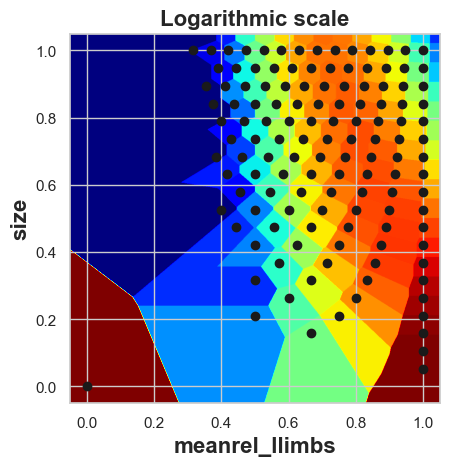

In [98]:
from scipy.interpolate import griddata

col1 = "meanrel_llimbs"
col2 = "size"
logarithmic = True
unique = False

# Get points
points = (df.loc[:, [col1, col2]] - df.loc[:, [col1, col2]].min(axis = 0)) / (df.loc[:, [col1, col2]].max(axis = 0) - df.loc[:, [col1, col2]].min(axis = 0))
if unique:
    points["values"] = df.groupby([col1, col2]).transform("size") # Unique counts
else:
    points["values"] = df.groupby([col1, col2])["count"].transform("sum") # Nonunique counts

# Drop duplicates
points = points.drop_duplicates([col1, col2])
values = points["values"].values
if logarithmic:
    values = np.log(values + 1) # Logarithmic scale
coordinates = points.loc[:, [col1, col2]].values

# Creat a meshgrid
mins = coordinates.min(axis = 0)
maxs = coordinates.max(axis = 0)
grid_x, grid_y = np.mgrid[mins[0]:maxs[0]:1000j, mins[1]:maxs[1]:1000j]

# Interpolate
grid_z0 = griddata(coordinates, values, (grid_x, grid_y), method='nearest', fill_value = np.nan) # nearest, linear, cubic

# Plot
plt.imshow(grid_z0.T, extent=(mins[0] - 0.05, maxs[0] + 0.05, mins[1] - 0.05, maxs[1] + 0.05), origin='lower', cmap = "jet")
plt.scatter(coordinates[:, 0], coordinates[:, 1], c = "k")
plt.xlabel(col1, fontsize = 16, fontweight = "bold")
plt.ylabel(col2, fontsize = 16, fontweight = "bold")
if logarithmic:
    plt.title("Logarithmic scale", fontsize = 16, fontweight = "bold")
else:
    plt.title("Non-logarithmic scale", fontsize = 16, fontweight = "bold")
plt.show()